In [22]:
from tensorflow import keras
from keras.models import Model,load_model
from keras.layers import MaxPooling2D, Flatten, Dense, Conv2D, Dropout, BatchNormalization
from keras import layers, optimizers
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os.path as path
import glob
import matplotlib.cm as cm
from IPython.display import Image, display
from keras.applications.imagenet_utils import * 

In [23]:
model=[0]*10
model[0] = load_model('./model_0')
model[0].summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 512, 1)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 512, 1)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 512, 1)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 256, 512, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 256, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 256, 16)      1168  

In [24]:
model[1] = load_model('./model_1')
model[1].summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 512, 1)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 512, 1)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 256, 512, 1)      0         
 tation)                                                         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 512, 8)       80        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 256, 8)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 256, 16)      1168

In [25]:
model[2] = load_model('./model_2')
model[2].summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 512, 1)]     0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 256, 512, 1)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 256, 512, 1)      0         
 tation)                                                         
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 512, 8)       80        
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 256, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 256, 16)      1168

In [26]:
for idx in range(3,10):
  model[idx] = load_model(f'./model_{idx}')
  print(f'model {idx} done')
  

In [27]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size,color_mode="grayscale")
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array,training = False)

        class_channel = preds[0]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    #print(last_conv_layer_output)
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    #print(heatmap)
    heatmap = tf.squeeze(heatmap)
    #print(heatmap)
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    #grad_model.summary()
    return heatmap.numpy()


In [99]:
# using img path
def heatmap_process_1(img_path) :

  preprocess_input = keras.applications.xception.preprocess_input

  # Prepare image
  img_size = (256,512)
  img_array = preprocess_input(get_img_array(img_path, size=img_size))

  #print(img_array.shape)
 
  heatmap=[0]*10

  for idx in range(0,10):
    n = 4+5*idx
    last_conv_layer_name = f'conv2d_{n}'
    # Remove last layer's sigmoid
    model[idx].layers[-1].activation = None

    # Print what the top predicted class is
    preds = model[idx].predict(img_array)
    #print(np.argmax(preds)) # this is used for softmax

    # Generate class activation heatmap
    heatmap[idx] = make_gradcam_heatmap(img_array, model[idx], last_conv_layer_name)

    #Display heatmap
    #plt.matshow(heatmap[idx])
    #plt.show()
  
  heatmap_sum = np.array(heatmap[0])
  for idx in range(1,10):
    heatmap_sum = heatmap[idx] + heatmap_sum
  # Display heatmap sum
  # plt.matshow(heatmap_sum)
  # plt.show()
  heatmap_mean = np.array(heatmap_sum) / 5 #model cnt

  return heatmap_mean 




# using img array  => shape=(batch, N, N', 1)
def heatmap_process_2(img_array) :

  preprocess_input = keras.applications.xception.preprocess_input

  # Prepare image
  #img_size = (256,512)
  #img_array = preprocess_input(get_img_array(img_path, size=img_size))

  #print(img_array.shape)
 
  heatmap=[0]*10

  for idx in range(0,10):
    n = 4+5*idx
    last_conv_layer_name = f'conv2d_{n}'
    # Remove last layer's sigmoid
    model[idx].layers[-1].activation = None

    # Print what the top predicted class is
    preds = model[idx].predict(img_array)
    #print("Predicted:", decode_predictions(preds, top=6)[0])
    #print(preds)

    # Generate class activation heatmap
    #pred_index = 0 # 0=20  1=70
    heatmap[idx] = make_gradcam_heatmap(img_array, model[idx], last_conv_layer_name)

    #Display heatmap
   # plt.matshow(heatmap[idx])
   # plt.show()
  
  heatmap_sum = np.array(heatmap[0])
  for idx in range(1,10):
    heatmap_sum = heatmap[idx] + heatmap_sum
  # plt.matshow(heatmap_sum)
  # plt.show()
  heatmap_mean = np.array(heatmap_sum) / 5

  return heatmap_mean 



In [100]:
# using img path
def save_and_display_gradcam_1(img_path, heatmap, cam_path="cam.jpg", alpha=0.6):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)
    
    # Display Grad CAM 
    
    display(Image(cam_path, width = 512, height=256)) 

# using img array  => shape=(N, N', 1)
def save_and_display_gradcam_2(img, heatmap, cam_path="cam.jpg", alpha=0.6):
    # Load the original image
    #img = keras.preprocessing.image.load_img(img_path)
    #img = keras.preprocessing.image.img_to_array(img)
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)
    
    # Display Grad CAM 
    
    display(Image(cam_path, width = 512, height=256))



In [113]:
x = np.load('./x.npy')
y = np.load('./y.npy')

In [114]:
x = np.expand_dims(x, -1)

In [115]:
x_test.shape

(1, 256, 512, 1)

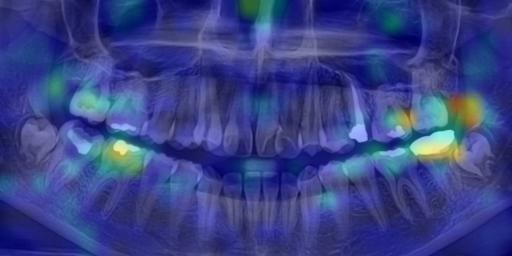

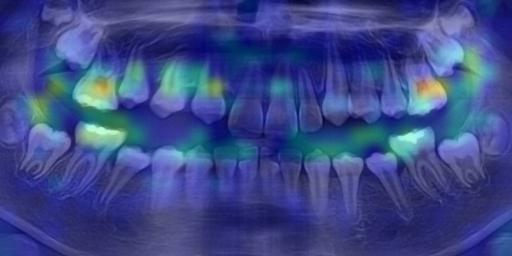

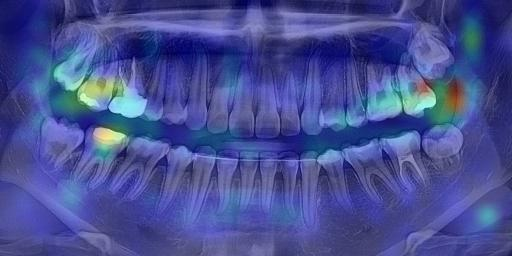

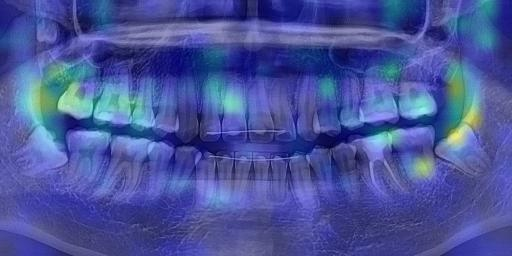

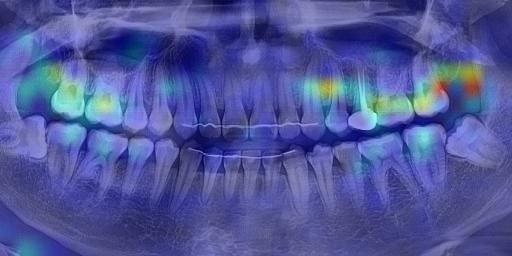

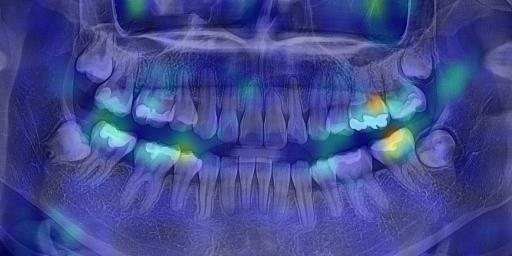

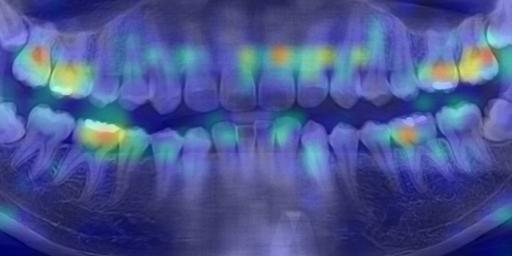

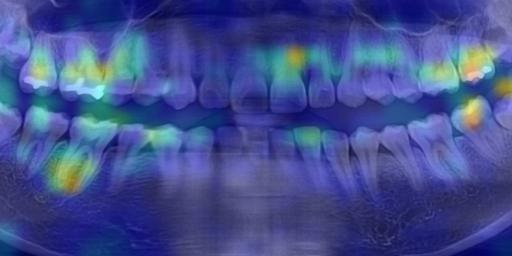

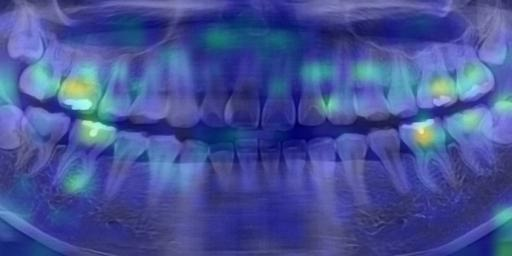

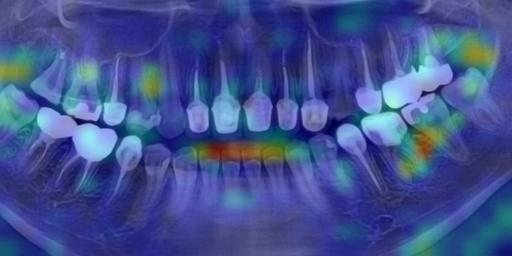

In [116]:
for idx in range(0,10):
  x_test = np.expand_dims(x[idx], 0)
  x_test = x_test/255
  heatmap_mean = heatmap_process_2(x_test)
  save_and_display_gradcam(x[idx],heatmap_mean)   